Capstone Project - Applied Data Science Capstone by IBM/Coursera

# **Optimal locations to open a Chinese restaurant in Stuttgart, Germany - *Strategic decision making using machine learning***
Cao, July 01, 2020

## **Table of contents**
1. [Introduction/Business Problem](#introduction)  
2. [Data](#data)  
    2.1. [Data sources](#datasource)  
    2.2. [Data cleaning](#datacleaning)    
3. [Methodology](#methodology)  
    3.1. [Exploratory data analysis](#exploratory) 
          3.1.1. Feature changes over time  
          3.1.2. Folium map
          3.1.3. Existing restaurants using Foursquare API 
    3.2. [Unsupervised machine learning model with clustering](#clustering)
          3.2.1. Pre-processing  
          3.2.2. Normalization
          3.2.3. Modeling 
4. [Results](#results)
5. [Discussion](#discussion)
6. [Conclusion](#conclusion)

<a name="introduction"></a>
## **1. Introduction/Business Problem** 

The success of opening a new restaurant depends on several factors: location, menu, customers, competition and so on. A restaurant's location is as crucial to its success as great food and service. Therefore, it is of utmost importance to determine the location in a strategic way in order to maximize business profits.

To the audiences who are interested in opening a Chinese restaurant in Stuttgart Germany, the data analysis in this project will tell them in which regions of Stuttgart to look for the optimal location. The restaurant concept and cuisine type define the demographics and psychographics of the ideal customers. A Chinese restaurant in western cities provides exotic tastes for the local people without traveling to China. The age and density of the population in the area determine the attraction of the restaurant and therefore would be considered with the competition by leveraging the Foursquare location data to solve the business problem.

Fellow entrepreneurs who plan to open their first Chinese restaurant or to expand their franchised restaurants in Stuttgart would be very interested in the insights of this report for competitive advantages and business values. Those who seeking to establish an asian restaurant may also be interested.

<a name="data"></a>
## **2. Data**

<a name="datasource"></a>
#### **2.1. Data sources**

As described in the business problem, the following aspects will be combined and considered for the decision making. Namely, 

- Stuttgart regions and their relevant population information including density, density of age group between 20 and 65, average age;
- geographical coordinate of each region;
- number of existing restaurants in each region which are grouped into three categories: Chinese restaurant, asian restaurant and other restaurant for the competition study.

The population information in Stuttgart area from year 2001 to 2019 can be found on the [Stuttgart website](https://www.stuttgart.de/statistik-stadtbezirke). The data in Excel format are provided by [Statistikatlas Stuttgart](https://statistik.stuttgart.de/statistiken/statistikatlas/atlas/atlas.html?indikator=i0&select=00) and are downloaded as 'Statistikatlas_Stuttgart_Datentabelle_Stadtbezirke.xlsx' for the further use. Geographical coordinate of each region will be obtained using the Geocoder package for the address near the region center. The Foursquare location API is used to search the existing restaurants in the vicinity of each region.

<a name="datacleaning"></a>
#### **2.2. Data cleaning**

Stuttgart has altogether 23 regions. The names of the regions are imported from the Excel table. One of the key points to locate a restaurant is a good reachability of the place either by cars or by public transportations. Specially for a Chinese restaurant, a certain percentage of the customers will be Chinese overseas students who may not have cars. Therefore, the town hall of each region which usually locates in the center and is easily reachable will be defined as the address for Geocoder to get the latitude and longitude coordinates for the Foursquare searching later on.

*Remark: For some regions, Geocoder fails to get the correct coordinates by only giving 'town hall' in the address. Hence, a specific address near the region center is explicitly given.*

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import pandas as pd
import numpy as np
from operator import add

num_regions = 23

# get the region names of Stuttgart
name_regions = pd.read_excel(client.get_object(Bucket=bucket,Key=key)['Body'],
                           sheet_name='Bevölkerung im Überblick',skiprows=5,nrows=23,usecols=[0])['Stadtbezirk / Jahr'].str.slice(start = 5).tolist()

# define the search center of each region at the town hall
address_regions = name_regions
address_regions[0:5] = list(map(add, ['Stuttgart-']*len(address_regions[0:5]), address_regions[0:5]))
address_regions = list(map(add, ['Town hall ']*len(address_regions), address_regions))
address_regions[5:23] = list(map(add, address_regions[5:23], [' Stuttgart']*len(address_regions[5:23])))

# refine the search center for some regions due to the inaccuracy of geopy
address_regions[3] = 'Stuttgart-Süd Böblinger Str. 135'
address_regions[10] = 'Town hall Stuttgart Hedelfingen'
address_regions[-9] = 'Augsburger Str. 659, Obertürkheim Stuttgart'
address_regions[-8] = 'Filderhauptstraße 155, Plieningen Stuttgart'
address_regions[-7] = 'Kirchheimer Str. 65, Sillenbuch Stuttgart'
address_regions[-6] = 'Münchinger Str.21, Stammheim Stuttgart'
address_regions[-4] = 'Town hall Stuttgart Vaihingen'

Population and its density of each region from year 2001 to 2019 are imported and the region area is calculated. The region area is further used to obtain the population density of the age group between 20 and 65 which can better describe the potentiality of customers in each region. The average age is also imported from the data source as one of the features.

In [3]:
# years of data
years = list(map(str, range(2001,2020)))

In [4]:
# define columns to import
col_table1 = np.linspace(2,20,19,dtype=int).tolist()

# population density, namely, population per squarekilometer of the region area
df_density = pd.read_excel(client.get_object(Bucket = bucket,Key = key)['Body'], sheet_name = 'Bevölkerung im Überblick', skiprows = 5, nrows = 23, usecols = col_table1)
df_density['Regions'] = name_regions
df_density.set_index('Regions', inplace=True)

# set the type of column names from int into string
df_density.columns = years

# calculate total population of all years and sort it by the total
df_density['Total'] = df_density.sum(axis=1)
df_density_sorted = df_density.sort_values(['Total'], ascending=False, axis=0)
df_density.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Total
Regions,,,,,,,,,,,,,,,,,,,,
Stuttgart-Mitte,5340,5370,5317,5341,5362,5394,5448,5480,5443,5482,5575,5712,5851,5924,6165,6237,6262,6322,6340,108365
Stuttgart-Nord,3534,3525,3518,3526,3524,3555,3573,3567,3556,3594,3632,3646,3743,3759,3909,4081,4062,4094,4068,70466
Stuttgart-Ost,4977,4975,4933,4936,4940,4926,4967,4982,5015,5009,5072,5109,5185,5227,5288,5323,5351,5371,5416,97002
Stuttgart-Süd,4251,4273,4259,4269,4278,4272,4272,4322,4348,4387,4431,4453,4482,4543,4572,4620,4622,4652,4613,83919
Stuttgart-West,6814,6816,6769,6805,6808,6844,6933,6957,6944,7017,7178,7269,7345,7416,7530,7518,7535,7558,7640,135696


In [5]:
# import relevant data to calculate the area of each region
col_table3 = np.linspace(42,60,19,dtype=int).tolist()

# population of each region in 2019
df_population = pd.read_excel(client.get_object(Bucket=bucket,Key=key)['Body'],sheet_name='Bevölkerung im Überblick',skiprows=5,nrows=23,usecols=col_table3)
df_population['Regions'] = name_regions
df_population.set_index('Regions', inplace=True)

# set the type of column names from int into string
df_population.columns = years
df_population.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Regions,,,,,,,,,,,,,,,,,,,
Stuttgart-Mitte,20328,20444,20239,20335,20417,20541,20748,20870,20729,20876,21230,21751,22270,22548,23466,23738,23835,24060,24129
Stuttgart-Nord,24080,24020,23973,24028,24015,24223,24346,24306,24228,24490,24754,24851,25509,25618,26643,27812,27683,27903,27727
Stuttgart-Ost,45025,45012,44628,44657,44691,44568,44938,45076,45380,45326,45826,46160,46843,47224,47776,48088,48344,48526,48929
Stuttgart-Süd,40697,40913,40782,40871,40954,40895,40896,41369,41620,41993,42477,42681,42970,43561,43833,44299,44318,44601,44227
Stuttgart-West,47135,47135,46805,47060,47088,47318,47940,48098,48010,48503,49625,50248,50767,51250,52037,51951,52064,52214,52777


In [6]:
# calculate the region area
df_regions_area = df_population[years].div(df_density[years])
df_regions_area.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Regions,,,,,,,,,,,,,,,,,,,
Stuttgart-Mitte,3.806742,3.807076,3.806470,3.807339,3.807721,3.808120,3.808370,3.808394,3.808378,3.808099,3.808072,3.807948,3.806187,3.806212,3.806326,3.805996,3.806292,3.805758,3.805836
Stuttgart-Nord,6.813809,6.814184,6.814383,6.814521,6.814699,6.813783,6.813882,6.814130,6.813273,6.814135,6.815529,6.815963,6.815122,6.815110,6.815810,6.814996,6.815116,6.815584,6.815880
Stuttgart-Ost,9.046614,9.047638,9.046827,9.047204,9.046761,9.047503,9.047312,9.047772,9.048853,9.048912,9.035095,9.035036,9.034330,9.034628,9.034796,9.034003,9.034573,9.034817,9.034158
Stuttgart-Süd,9.573512,9.574772,9.575487,9.573905,9.573165,9.572800,9.573034,9.571726,9.572217,9.572145,9.586324,9.584774,9.587238,9.588598,9.587270,9.588528,9.588490,9.587489,9.587470
Stuttgart-West,6.917376,6.915346,6.914611,6.915503,6.916569,6.913793,6.914756,6.913612,6.913882,6.912213,6.913486,6.912643,6.911777,6.910734,6.910624,6.910215,6.909622,6.908441,6.907984


In [7]:
# define columns to import
col_table4 = np.linspace(62,80,19,dtype=int).tolist()

# population between age 20 and 65
df_age20_65 = pd.read_excel(client.get_object(Bucket=bucket,Key=key)['Body'],sheet_name='Altersstruktur im Überblick',skiprows=38,nrows=23,usecols=col_table4)
df_age20_65['Regions'] = name_regions
df_age20_65.set_index('Regions', inplace=True)

# set the column names from int into string
df_age20_65.columns = years

# convert population into population density of the region area
df_density_age20_65 = df_age20_65[years].div(df_regions_area[years])
df_density_age20_65

# calculate total population of the years and sort it by the total 
df_density_age20_65['Total'] = df_density_age20_65.sum(axis=1)
df_density_age20_65_sorted = df_density_age20_65.sort_values(['Total'], ascending=False, axis=0)
df_density_age20_65.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Total
Regions,,,,,,,,,,,,,,,,,,,,
Stuttgart-Mitte,3929.082054,3971.288887,3928.574435,3950.002410,3960.111574,3976.240105,4046.350492,4076.783900,4062.884799,4120.690937,4218.933114,4345.384764,4472.717737,4521.030335,4705.850166,4769.316033,4773.412125,4837.670075,4832.840980,81499.164922
Stuttgart-Nord,2312.216362,2302.403206,2283.112001,2277.342850,2278.310389,2293.145977,2294.727183,2288.920390,2275.264652,2302.126501,2329.092995,2329.238099,2412.722921,2423.144898,2517.089067,2624.799655,2646.910306,2678.860768,2657.910629,45527.338849
Stuttgart-Ost,3274.484642,3275.219386,3248.099960,3241.222294,3232.317021,3218.014943,3241.183586,3261.465924,3290.030079,3304.927724,3370.302274,3408.287392,3481.829943,3504.405535,3547.285499,3586.781921,3614.670011,3630.400198,3675.605387,64406.533719
Stuttgart-Süd,2953.566012,2971.767947,2964.131161,2960.338577,2967.566099,2951.278738,2963.532864,2997.996374,3019.467660,3071.202962,3113.498058,3125.999531,3159.721340,3204.848144,3231.055232,3261.814488,3260.471727,3285.740320,3257.480792,58721.478027
Stuttgart-West,4761.053909,4761.728312,4726.224121,4743.400234,4738.621305,4766.992519,4842.253630,4894.257745,4874.829744,4959.337773,5124.043325,5203.364532,5262.033408,5308.987785,5389.382939,5390.135820,5401.598129,5411.206075,5462.230138,96021.681442


In [8]:
# average age
df_ave_age = pd.read_excel(client.get_object(Bucket=bucket,Key=key)['Body'],sheet_name='Altersstruktur im Überblick',skiprows=5,nrows=23,usecols=col_table1)
df_ave_age['Regions'] = name_regions
df_ave_age.set_index('Regions', inplace=True)

# set the column names from int into string
df_ave_age.columns = years

# calculate total average age of the years and sort it by the total
df_ave_age['Total'] = df_ave_age.sum(axis=1)
df_ave_age_sorted = df_ave_age.sort_values(['Total'], ascending=False, axis=0)
df_ave_age.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Total
Regions,,,,,,,,,,,,,,,,,,,,
Stuttgart-Mitte,40.1,40.1,40.0,40.0,39.9,39.9,39.8,39.5,39.6,39.5,39.3,39.3,39.2,39.1,38.7,38.7,38.6,38.7,38.7,748.7
Stuttgart-Nord,41.2,41.2,41.2,41.2,41.3,41.3,41.4,41.3,41.5,41.7,41.9,42.0,41.9,42.0,41.4,40.8,41.1,41.3,41.6,787.3
Stuttgart-Ost,41.5,41.5,41.6,41.6,41.6,41.5,41.5,41.5,41.5,41.6,41.5,41.5,41.6,41.5,41.3,41.4,41.4,41.3,41.3,788.2
Stuttgart-Süd,40.8,40.9,40.9,40.9,40.9,40.9,40.9,40.9,40.8,40.7,40.6,40.5,40.5,40.4,40.2,40.2,40.2,40.3,40.6,772.1
Stuttgart-West,41.3,41.3,41.5,41.3,41.3,41.2,41.0,40.9,41.0,40.8,40.5,40.4,40.3,40.3,40.1,40.2,40.3,40.4,40.3,774.4


<a name="methodology"></a>
## **3. Methodology** 

<a name="exploratory"></a>
### **3.1. Exploratory data analysis**

#### **3.1.1. Feature changes over time**

A quick visualization for population density, population density aged 20~65 and average age from year 2001 to 2019 is shown below using stacked area plots. As we can see from the three area plots, the feature changes of each region are slow over time, especially the change of the average age. Hence, only the data of the latest year 2019 for each region will be merged into the feature dataframe for the machine learning modeling. 

In [9]:
df_density_transposed = df_density_sorted[years].transpose()
#df_density_transposed

df_density_age20_65_transposed = df_density_age20_65_sorted[years].transpose()
#df_density_age20_65_transposed

df_ave_age_transposed = df_ave_age_sorted[years].transpose() 
#df_ave_age_transposed

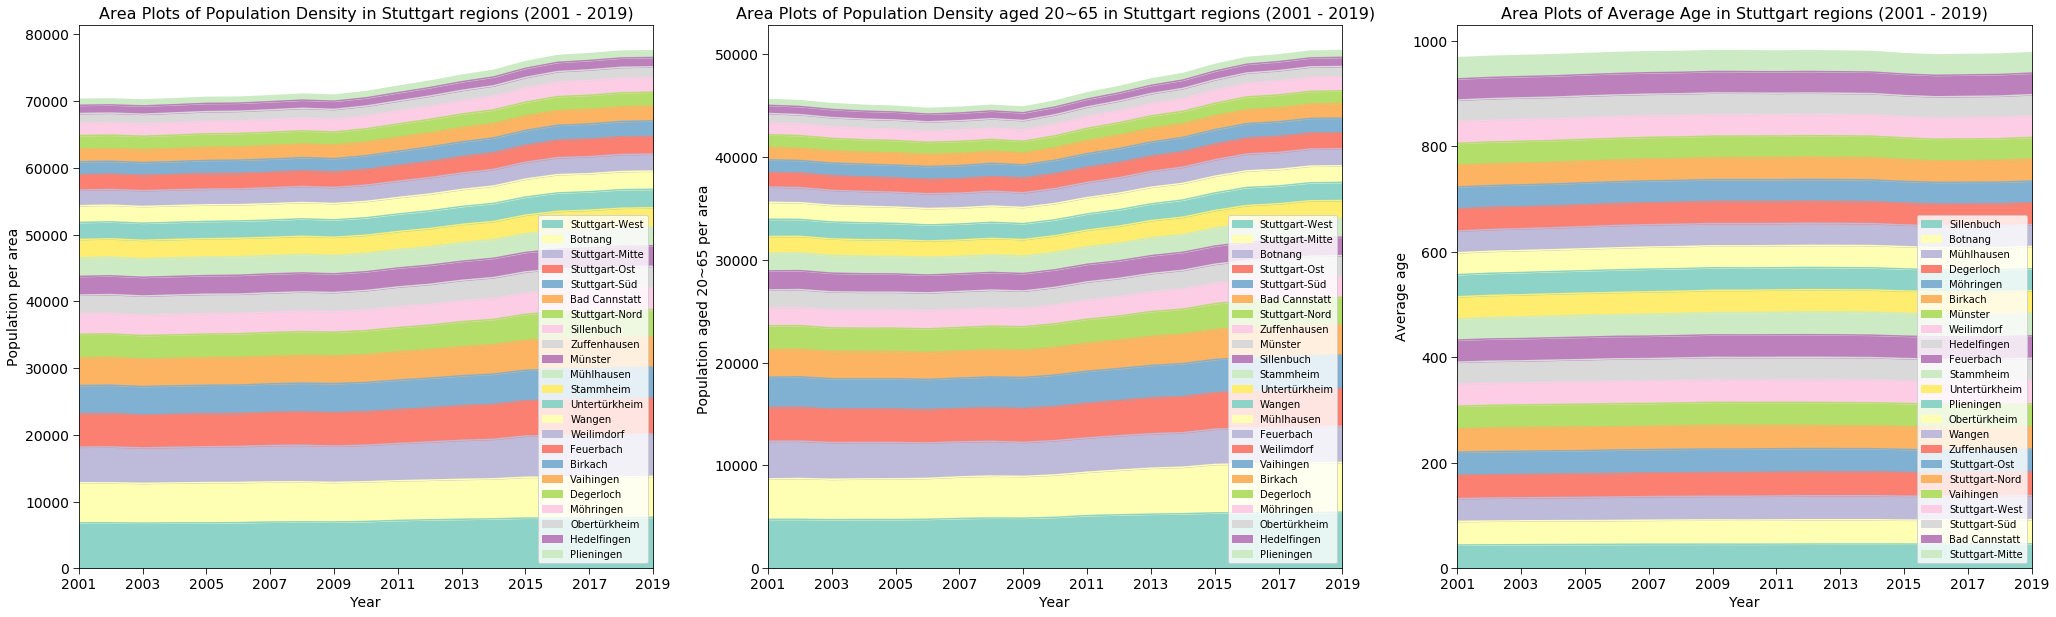

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

fig_area = plt.figure(figsize=(35,10))

ax0_area = fig_area.add_subplot(1,3,1)
ax1_area = fig_area.add_subplot(1,3,2)
ax2_area = fig_area.add_subplot(1,3,3)

pal = sns.color_palette('Set3')

# area plots for 3 parameters
df_density_transposed.plot(kind='area', ax=ax0_area, color=pal, alpha=1.0)
df_density_age20_65_transposed.plot(kind='area', ax=ax1_area, color=pal, alpha=1.0)
df_ave_age_transposed.plot(kind='area', ax=ax2_area, color=pal, alpha=1.0)

ax0_area.set_title('Area Plots of Population Density in Stuttgart regions (2001 - 2019)', fontsize=16)
ax0_area.set_xlabel('Year', fontsize=14)
ax0_area.set_ylabel('Population per area', fontsize=14)
ax0_area.tick_params(axis='x',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax0_area.tick_params(axis='y',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax0_area.legend(loc='lower right', fontsize=10)

ax1_area.set_title('Area Plots of Population Density aged 20~65 in Stuttgart regions (2001 - 2019)', size=16)
ax1_area.set_xlabel('Year', fontsize=14)
ax1_area.set_ylabel('Population aged 20~65 per area ', fontsize=14)
ax1_area.tick_params(axis='x',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax1_area.tick_params(axis='y',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax1_area.legend(loc='lower right', fontsize=10)

ax2_area.set_title('Area Plots of Average Age in Stuttgart regions (2001 - 2019)', size=16)
ax2_area.set_xlabel('Year', fontsize=14)
ax2_area.set_ylabel('Average age', fontsize=14)
ax2_area.tick_params(axis='x',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax2_area.tick_params(axis='y',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax2_area.legend(loc='lower right', fontsize=10)

Merge three features of the year 2019 into one dataframe.

In [11]:
df_regions_info = df_density[['2019']]
df_regions_info.columns = ['Population Density']
df_regions_info['Population Density Age 20~65'] = df_density_age20_65['2019']
df_regions_info['Average Age'] = df_ave_age['2019']
df_regions_info.reset_index(inplace=True)
df_regions_info.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Regions,Population Density,Population Density Age 20~65,Average Age
0,Stuttgart-Mitte,6340,4832.840980,38.7
1,Stuttgart-Nord,4068,2657.910629,41.6
2,Stuttgart-Ost,5416,3675.605387,41.3
3,Stuttgart-Süd,4613,3257.480792,40.6
4,Stuttgart-West,7640,5462.230138,40.3


#### **3.1.2. Folium map**

The Geocoder package and Folium library are used to get the latitude and longitude values of each region center and to geographically visualize the distribution of each region in Stuttgart with markers (see map below). The radius of markers is set to 1 km which will be later on also applied to the Foursquare API as the searching radius for existing restaurants. The markers with the actual searching radius can give an intuitional illustration for the coverage of the searching. The reason for choosing 1 km radius is that this distance is reachable on foot around 10~12 minutes and there are no big overlapping between every two neighbor regions. 

In [12]:
# download all the dependencies needed
import json # library to handle JSON files

!pip -q install geopy
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!pip -q install folium
import folium # map rendering library

In [13]:
# function to get latitude and longitude values of an address
def get_coord(address):
    try:
        lat = []
        lng = []
        for i in address:
            geolocator = Nominatim(user_agent="ny_explorer")
            loc = geolocator.geocode(i)
            lat.append(loc.latitude)
            lng.append(loc.longitude)
        return [lat,lng]
    except:
        return [None, None]

In [14]:
# function to add markers with radius 1000m to map
def add_markers(map_name, latitudes, longitudes, regions, search_radius):
    for lat, lng, region in zip(latitudes, longitudes, regions):
        label = '{}'.format(region)
        label = folium.Popup(label, parse_html=True)
        folium.Circle(
            [lat, lng],
            radius=search_radius,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_name)  

In [15]:
# get latitude and longitude values of each region
lat_lng = get_coord(address_regions)

# create map with markers using latitude and longitude values of each region
map_stgt = folium.Map(location=[lat_lng[0][0], lat_lng[1][0]], zoom_start=12)

# search radius later on for the searching in Foursquare is used to draw the markers on the map
search_radius = 1200
add_markers(map_stgt, lat_lng[0], lat_lng[1], address_regions, search_radius)
map_stgt

#### **3.1.3. Existing restaurants using Foursquare API**

As mentioned in section 3.1.2., the searching radius using Foursquare API is set to 1 km. The searching results are grouped into three categories in terms of the category names in Foursquare for the analysis afterwards: Chinese restaurant, asian restaurant and other restaurant. The idea behind the grouping is the similarities, dissimilarities and the competition levels to the Chinese restaurants. The cuisine and style of the asian restaurants are quite similar among each other in comparison to the western, South American or African restaurants. The existing Chinese restaurants are of course the direct competitors and the other asian restaurants are also quite competitive due to the exotic similarities. The grouping gives a quick and more clear exploration of the number distribution. 

In [16]:
# The code was removed by Watson Studio for sharing.

In [17]:
def getNearbyRestaurants(names, latitudes, longitudes, radius):
    
    restaurants_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=restaurant'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        if (len(results) == 0):
            print('Foursquare does not find any restaurants within the radius ', radius,' m near ', name)

        # return only relevant information for each nearby restaurant
        asian_list = ['Indian Restaurant', 'Japanese Restaurant', 'Sushi Restaurant', 'Thai Restaurant', 'Vietnamese Restaurant']
        for v in results:
            if v['categories'] != []:
                if v['categories'][0]['name'] in asian_list:
                    restaurants_list.append([(
                        name, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        'Asian Restaurant')])
                elif v['categories'][0]['name'] in ['Chinese Restaurant', 'Szechuan Restaurant']:
                    restaurants_list.append([(
                        name, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        'Chinese Restaurant')])
                else:
                    restaurants_list.append([(
                        name, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        'Other Restaurant')])                 
        
    nearby_restaurants = pd.DataFrame([item for restaurant_list in restaurants_list for item in restaurant_list])
    nearby_restaurants.columns = ['Regions',           
                  'Restaurant', 
                  'Restaurant Latitude', 
                  'Restaurant Longitude', 
                  'Restaurant Category']
    
    return(nearby_restaurants)

In [18]:
# get restaurant information and create a dataframe.
LIMIT = 50
df_restaurants = getNearbyRestaurants(name_regions, lat_lng[0], lat_lng[1], search_radius)
df_restaurants.head()

,Regions,Restaurant,Restaurant Latitude,Restaurant Longitude,Restaurant Category
0,Stuttgart-Mitte,China-Restaurant Shanghai,48.774828,9.184219,Chinese Restaurant
1,Stuttgart-Mitte,DINEA Café & Restaurant,48.773449,9.176041,Other Restaurant
2,Stuttgart-Mitte,Shima Restaurant,48.769887,9.180345,Asian Restaurant
3,Stuttgart-Mitte,DINEA Café & Restaurant,48.781775,9.180324,Other Restaurant
4,Stuttgart-Mitte,Restaurant WEISSENHOF,48.788238,9.180666,Other Restaurant


<a name="clustering"></a>
#### **3.2. Unsupervised machine learning model with clustering**

Since we know little to the outcomes that are to be expected for the optimal location of a new opening Chinese restaurant, **clustering** would be a proper machine learning technique to discover demographic structure and restaurant distribution in Stuttgart area. There are many models for clustering out there. I select the **K-Means** which is vastly used for clustering in many data science applications, especially useful to quickly discover insights from unlabeled data as for our case. By segmenting and clustering the regions, a recommendation for optimal location candidates will be given.

Essentially, determining the number of clusters in a data set, or K as in the K-Means algorithm, is a frequent problem in data clustering. The correct choice of K is often ambiguous because it is very dependent on the shape and scale of the distribution of points in a dataset. Here, I use the elbow method with the help of **KElbowVisualizer** to select the optimal number of clusters by fitting the model with a range of values from 1 to 10 for K. The scoring parameter **metric** is by default set to **distortion**, also as attribute **inertia**, which computes the sum of squared distances of samples to their closest cluster center.

#### **3.2.1. Pre-processing**

The existing restaurants of each region searched from Foursquare are collected in the dataframe column 'Restaurant Category' which is a categorical variable. The K-Means algorithm cannot operate on such variables directly because Euclidean distance function is not really meaningful for discrete variables. It requires all input variables and output variables to be numeric. Here, I use **One-hot encoding** to convert the categorical data to numerical data. After encoding, the number of existing restaurants for the three cuisines (Chinese, asian and other) is obtained for each region. These features combined with population density and average age (see table below) are prepared for the machine learning model.

In [19]:
# one hot encoding
df_onehot = pd.get_dummies(df_restaurants[['Restaurant Category']], prefix="", prefix_sep="")
df_onehot

# insert regions for 'groupby'
df_onehot.insert(loc=0, column='Regions', value=df_restaurants['Regions'])

# let's group rows by regions and by taking the sum of the frequency of occurrence of each category
df_restaurants_grouped = df_onehot.groupby('Regions').sum().reset_index()
df_restaurants_grouped.head()

,Regions,Asian Restaurant,Chinese Restaurant,Other Restaurant
0,Bad Cannstatt,0,0,12
1,Birkach,0,0,1
2,Botnang,0,0,3
3,Degerloch,0,0,4
4,Feuerbach,1,0,3


In [20]:
# append the restaurant information to the feature dataframe
df_regions_features = df_regions_info.join(df_restaurants_grouped.set_index('Regions'), on='Regions')
df_features = df_regions_features.drop(columns='Regions')
df_features.head()

,Population Density,Population Density Age 20~65,Average Age,Asian Restaurant,Chinese Restaurant,Other Restaurant
0,6340,4832.840980,38.7,5,3,34
1,4068,2657.910629,41.6,0,0,5
2,5416,3675.605387,41.3,1,1,9
3,4613,3257.480792,40.6,2,0,11
4,7640,5462.230138,40.3,2,1,9


#### **3.2.2. Normalization**

Altogether six features for the clustering have three different magnitudes and distributions for density, age and number. In order to interpret theses features equally, we use **StandardScalar()** to normalize the dataset over the standard deviation using a statistical method.

In [21]:
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.cluster import KMeans  # for k-Means clustering

# normalize the dataset over the standard deviation
df_features_normalize = StandardScaler().fit_transform(df_features)
#df_features_normalize

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### **3.2.3. Modeling**

As mentioned before, I first use  **KElbowVisualizer** to determine the optimal number of clusters. The scoring parameter **distortion** as a blue solid line and the amount of time to train the clustering model per **K** as a dashed green line are displayed in the figure 'Distortion Score Elbow for KMeans Clustering' (see below). The optimal cluster number is marked as a dashed black line, in our case, 3 which is used to fit the model and get cluster labels. 

In [22]:
!pip -q install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


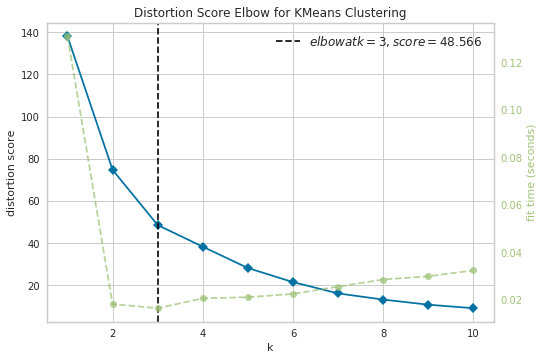

In [23]:
# Instantiate the clustering model and visualizer
model = KMeans(init='k-means++', random_state=0)
visualizer = KElbowVisualizer(model, k=(1,11))

# display elbow cluster number
visualizer.fit(df_features_normalize)
visualizer.show()

In [25]:
# set the optimal cluster number to 3
kclusters_opt = 3

# run K-Means clustering and fit the model
kmeans_opt = KMeans(n_clusters=kclusters_opt, init='k-means++', random_state=0).fit(df_features_normalize)

<a name="results"></a>
## **4. Results**

After the optimal clustering, let's merge the cluster labels into the feature dataframe, sort the values by column 'Cluster Labels' and visualize the resulting clusters in the map. The colorful markers show a radial distribution of the clusters. The region **Stuttgart-Mitte** alone constitutes **Cluster 0** (red) which is the center of the cluster distribution. The other four downtown regions surrounding the center, namely, **Stuttgart-Ost, Stuttgart-Süd, Stuttgart-West** and **Stuttgart Nord**, plus another two nearby regions **Botnang** and **Bad Cannstatt** form **Cluster 2** (green). The rest further outside the circle belongs to **Cluster 2** (purple).

In [26]:
# add cluster labels into the feature dataframe
df_regions_features.insert(1,'Cluster Labels', kmeans_opt.labels_)

In [32]:
# sort the feature dataframe by cluster labels
df_regions_features_sorted = df_regions_features.sort_values(by='Cluster Labels')
df_regions_features_sorted.set_index('Regions', inplace=True)
df_regions_features_sorted.head()

,Cluster Labels,Population Density,Population Density Age 20~65,Average Age,Asian Restaurant,Chinese Restaurant,Other Restaurant
Regions,,,,,,,
Stuttgart-Mitte,0,6340,4832.840980,38.7,5,3,34
Wangen,1,2732,1763.832906,41.4,0,0,4
Vaihingen,1,2208,1437.602705,41.1,1,0,8
Untertürkheim,1,2763,1737.672485,42.4,0,0,3
Stammheim,1,2879,1818.789499,43.2,0,0,1


In [28]:
# create map
map_clusters = folium.Map(location=[lat_lng[0][0], lat_lng[1][0]], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters_opt)
ys = [i + x + (i*x)**2 for i in range(kclusters_opt)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, name, cluster in zip(lat_lng[0], lat_lng[1], df_regions_features['Regions'], df_regions_features['Cluster Labels']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now I group the features in each cluster and calculate the mean values to get insights into the cluster properties. The mean values of six features are compared in the bar charts below for three clusters and are described as follows:
* **Cluster 0:**
    - high population density (also age 20~65)
    - average age: 38.7
    - lower middle number of direct competitors (Chinese & asian restaurants)
    - very high number of other competitors (other restaurants)
* **Cluster 1:**
    - low population density (also age 20~65)
    - average age: 43
    - very low number of direct competitors (Chinese & asian restaurants)
    - low number of other competitors (other restaurants)
* **Cluster 2:**
    - upper middle population density (also age 20~65)
    - average age: 41.8
    - low number of direct competitors (Chinese & asian restaurants)
    - lower middle number of other competitors (other restaurants)

In [29]:
# group the feature dataframe by cluster labels
df_regions_features_grouped = df_regions_features.groupby('Cluster Labels').mean()
df_regions_features_grouped

,Population Density,Population Density Age 20~65,Average Age,Asian Restaurant,Chinese Restaurant,Other Restaurant
Cluster Labels,,,,,,
0,6340.000000,4832.840980,38.700000,5.000000,3.000000,34.000000
1,2424.687500,1499.319772,43.000000,0.187500,0.375000,3.187500
2,5404.166667,3584.812275,41.783333,0.833333,0.333333,8.166667


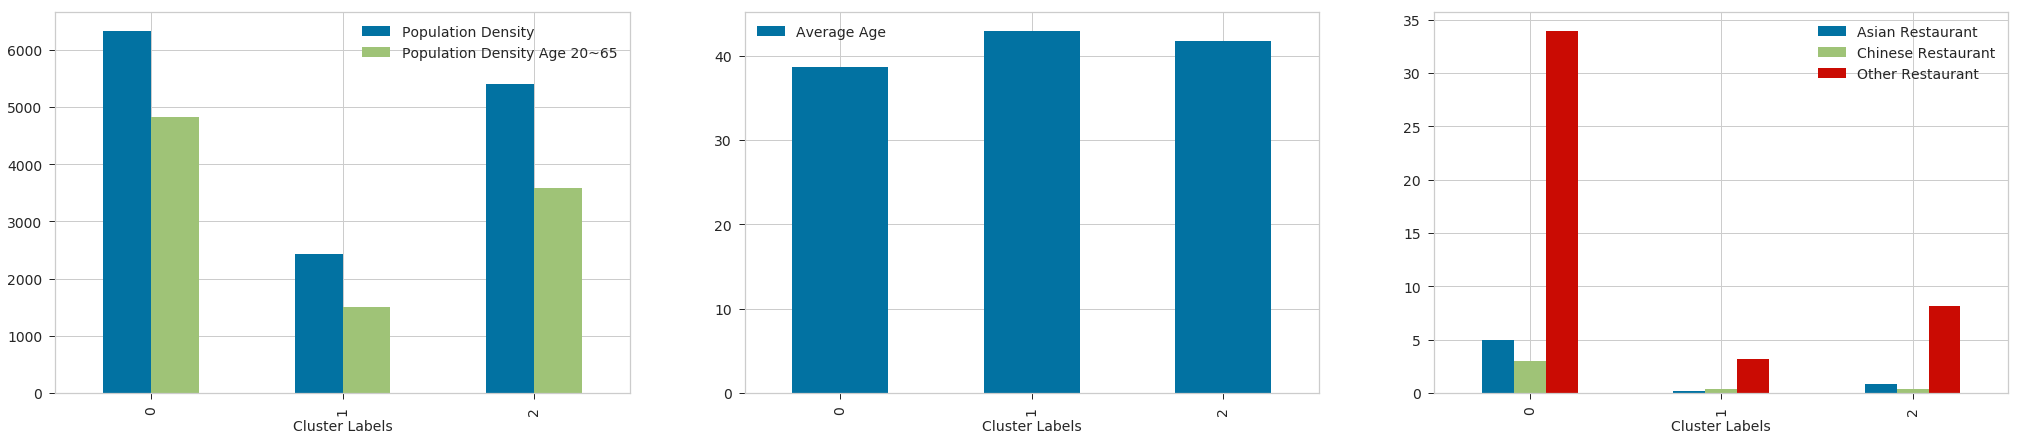

In [30]:
fig_bar_grouped = plt.figure(figsize=(35,7))

ax0_bar_grouped = fig_bar_grouped.add_subplot(1,3,1)
ax1_bar_grouped = fig_bar_grouped.add_subplot(1,3,2)
ax2_bar_grouped = fig_bar_grouped.add_subplot(1,3,3)

df_regions_features_grouped[['Population Density', 'Population Density Age 20~65']].plot(kind='bar', ax=ax0_bar_grouped)
df_regions_features_grouped[['Average Age']].plot(kind='bar', ax=ax1_bar_grouped)
df_regions_features_grouped[['Asian Restaurant', 'Chinese Restaurant', 'Other Restaurant']].plot(kind='bar', ax=ax2_bar_grouped)

ax0_bar_grouped.set_xlabel(xlabel='Cluster Labels', fontsize=14)
ax0_bar_grouped.tick_params(axis='x',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax0_bar_grouped.tick_params(axis='y',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax0_bar_grouped.legend(loc='best', fontsize=14)

ax1_bar_grouped.set_xlabel(xlabel='Cluster Labels', fontsize=14)
ax1_bar_grouped.tick_params(axis='x',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax1_bar_grouped.tick_params(axis='y',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax1_bar_grouped.legend(loc='best', fontsize=14)

ax2_bar_grouped.set_xlabel(xlabel='Cluster Labels', fontsize=14)
ax2_bar_grouped.tick_params(axis='x',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax2_bar_grouped.tick_params(axis='y',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax2_bar_grouped.legend(loc='best', fontsize=14)

Let's look more deeply into Cluster 2 with bar charts. The six features for each region in Cluster 2 are illustrated and compared. As before, the potential aspects of selecting the optimal locations are listed for each region:
* **Botnang:**
    - upper middle population density (age 20~65)
    - average age: 45.9
    - no Chinese restaurants
    - no asian restaurants    
    - low number of other restaurants
* **Bad Cannstatt:**
    - middle population density (age 20~65)
    - average age: 41
    - no Chinese restaurants
    - no asian restaurants    
    - high number of other restaurants
* **Stuttgart-West:**
    - high population density (age 20~65)
    - average age: 40.3
    - low number of Chinese restaurants
    - lower middle number of asian restaurants    
    - upper middle number of other restaurants
* **Stuttgart-Süd:**
    - middle population density (age 20~65)
    - average age: 40.6
    - no Chinese restaurants
    - lower middle number of asian restaurants    
    - high number of other restaurants
* **Stuttgart-Ost:**
    - upper middle population density (age 20~65)
    - average age: 41.3
    - low number of Chinese restaurants
    - low number of asian restaurants    
    - upper middle number of other restaurants
* **Stuttgart-Nord:**
    - lower middle population density (age 20~65)
    - average age: 41.6
    - no Chinese restaurants
    - no asian restaurants    
    - lower middle number of other restaurants

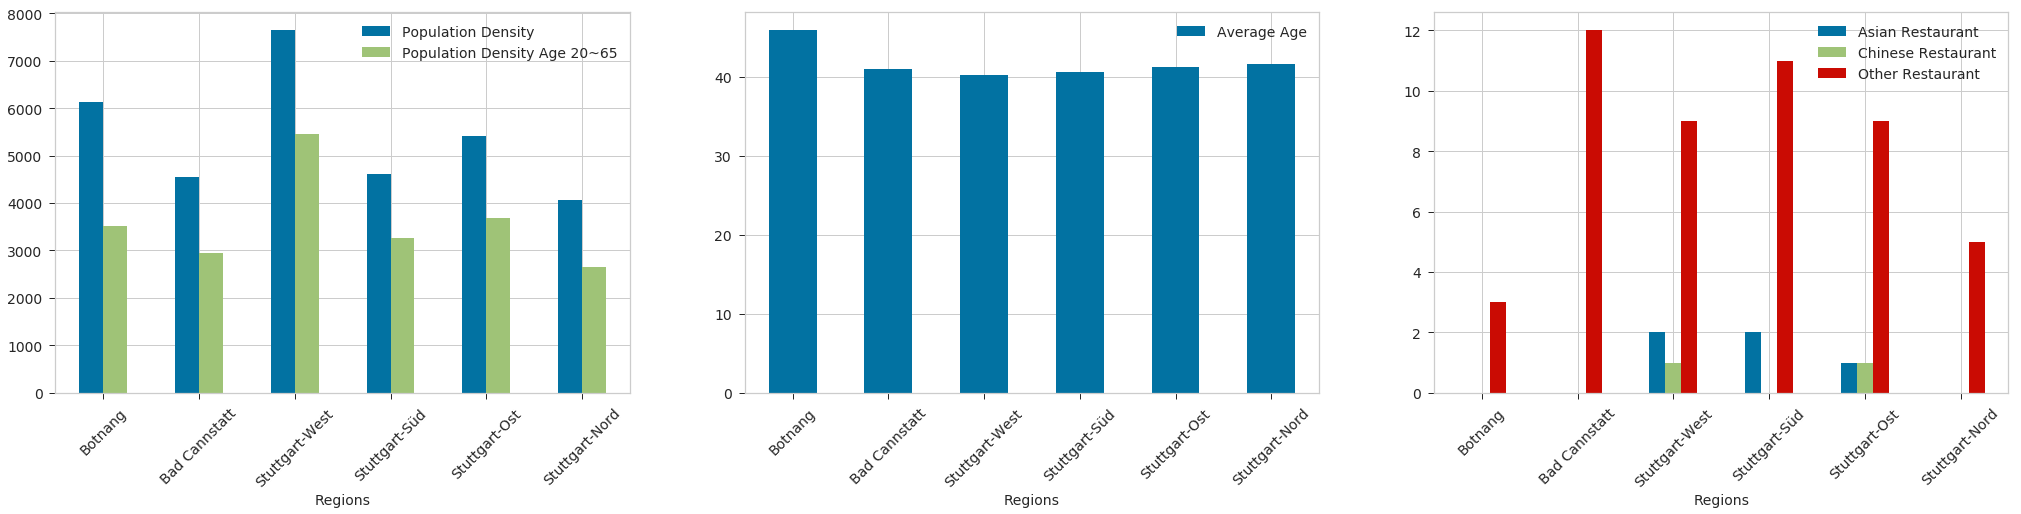

In [31]:
fig_bar_cluster2 = plt.figure(figsize=(35,7))

ax0_bar_cluster2 = fig_bar_cluster2.add_subplot(1,3,1)
ax1_bar_cluster2 = fig_bar_cluster2.add_subplot(1,3,2)
ax2_bar_cluster2 = fig_bar_cluster2.add_subplot(1,3,3)

df_regions_features_sorted.loc[df_regions_features_sorted['Cluster Labels']==2, ['Population Density', 'Population Density Age 20~65']].plot(kind='bar', ax=ax0_bar_cluster2)
df_regions_features_sorted.loc[df_regions_features_sorted['Cluster Labels']==2, ['Average Age']].plot(kind='bar', ax=ax1_bar_cluster2)
df_regions_features_sorted.loc[df_regions_features_sorted['Cluster Labels']==2, ['Asian Restaurant', 'Chinese Restaurant', 'Other Restaurant']].plot(kind='bar', ax=ax2_bar_cluster2)

ax0_bar_cluster2.set_xlabel(xlabel='Regions', fontsize=14)
ax0_bar_cluster2.tick_params(axis='x',which='major',direction='out',bottom=True,length=6,labelsize=14, rotation=45)
ax0_bar_cluster2.tick_params(axis='y',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax0_bar_cluster2.legend(loc='best', fontsize=14)

ax1_bar_cluster2.set_xlabel(xlabel='Regions', fontsize=14)
ax1_bar_cluster2.tick_params(axis='x',which='major',direction='out',bottom=True,length=6,labelsize=14, rotation=45)
ax1_bar_cluster2.tick_params(axis='y',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax1_bar_cluster2.legend(loc='best', fontsize=14)

ax2_bar_cluster2.set_xlabel(xlabel='Regions', fontsize=14)
ax2_bar_cluster2.tick_params(axis='x',which='major',direction='out',bottom=True,length=6,labelsize=14, rotation=45)
ax2_bar_cluster2.tick_params(axis='y',which='major',direction='out',bottom=True,length=6,labelsize=14)
ax2_bar_cluster2.legend(loc='best', fontsize=14)

<a name="discussion"></a>
## **5. Discussion**

Remember that the size of the searching circle for restaurants is the same for each region. This implies that the existing number of restaurants also represents the restaurant's concentration. The clustering analysis shows that highest concentration of restaurants is detected in Cluster 0, the very center area of Stuttgart. It is crowded with competitors of various cuisines including many Chinese/asian restaurants. In contrast, Cluster 2 has low ~ lower middle concentration of restaurants which is comparable with Cluster 1 from the competitor point of view but fairly closer to the center area. 

If we only focus on the customers from the region itself, the population density especially the age group 20\~65 plays an important role. The reason to target the people between 20 and 65 years old is that they are more likely to accept or like the asian cuisine than the other age group. Children until teenage may still be influenced by their parents and the very old generation may on one hand seldom go to restaurants and on the other hand be less international for other kitchens. The results show that the average population density (also age 20\~65) of Cluster 2 has a similar level as Cluster 0 but considerably higher than Cluster 1. Of course, customers are not limited to the region where a restaurant locates. The neighborhoods near the very center are more popular for shopping, relaxing, friends' gatherings, tourists and so on. Therefore, whether the customers from the region itself or from all surroundings, Cluster 2 is surely a potential candidate. 

At last, the average age of Cluster 0 is 38.7 which is 4.3 years younger than Cluster 1 and 3.1 years younger than Cluster 2. As mentioned before, a region with more younger adults may better activate the restaurant business. For this reason, Cluster 2 also stands on a positive position.

Overall, **Cluster 2** appears to be the most promising group of regions to the audiences for opening a new Chinese or an asian restaurant. More specifically and similar to the analysis for clusters, the list of the analysis results for the six regions in Cluster 2 would recommend **Stuttgart-Nord** as the optimal location.

The recommended cluster or concrete region is based on the available data we could find on the Internet. Some other relevant features like income, rental, amount of Chinese/asian migrants and even the business profits of existing restaurants will definitely contribute to a more detailed and accurate clustering model and guidance. In the future, the data set can be further expanded with these features whenever it is reachable for the model improvement and a second level of clustering for the optimal 1st-level cluster candidate can also be conducted when necessary.

<a name="conclusion"></a>
## **6. Conclusion**

The aim of this study is to identify an optimal location for opening a new Chinese restaurant in the city Stuttgart, Germany. Based on the available data, the population density including for the age group 20\~65, average age and the calculated restaurant density from Foursquare data among the most important features are determined for the strategic analysis. One prerequisite of the recommendation is defining a circle around each region center as the search target.

The unsupervised machine learning model 'K-Means' is implemented to cluster the regions for recognizing the major zone of interest which contains potential regions. I use the elbow method to identify the optimum K value as 3. The three resulted clusters can be well distinguished among each other and a clear choice is made for Cluster 2. Folium map, stacked area plots and bar charts are combined to illustrate the analysis results.

Final decision-making of a specific optimal location will be done by the audiences based on the recommendation of this study and their own liking of the regions. This study can also be applied to other interchangeable scenarios such as opening a restaurant of different cuisines.